In [9]:
import qpython.qconnection as qconn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
q = qconn.QConnection(host='localhost', port=5000)
q.open()
columns = ["Date", "Open" , "High", "Low", "Close",  "Adj_Close", "Volume", "Sym"]

In [5]:
def load_data_from_kdb(table_name):
    query = f"select from {table_name}"
    result = q.sendSync(query)
    # print(result)
    df = pd.DataFrame(result, columns= columns)
    return df

In [6]:
historical_data = load_data_from_kdb('stockData')

historical_data['Sym'] = historical_data['Sym'].str.decode('utf-8')
historical_data['Date'] = pd.to_datetime(historical_data['Date'], unit='D', origin='2000-01-01')

# Data Exploration
summary_statistics = historical_data.describe()

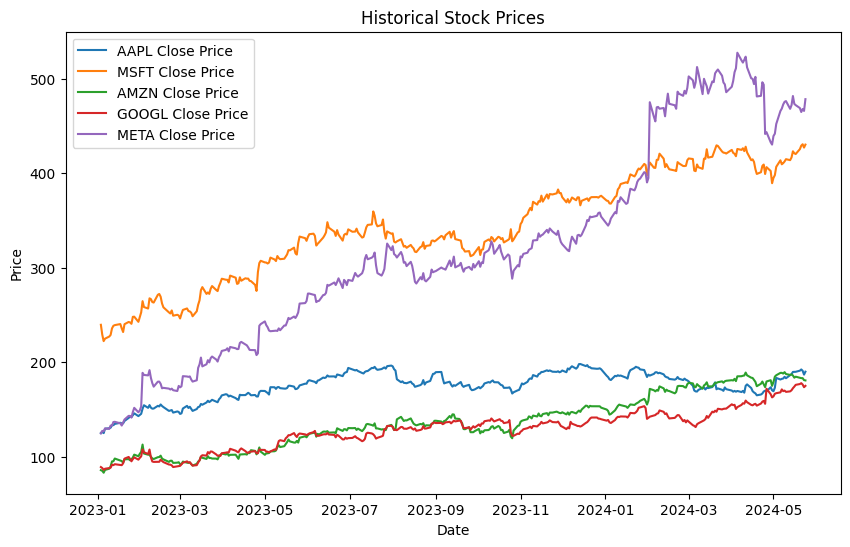

In [7]:
# Visualization
plt.figure(figsize=(10, 6))
for sym in historical_data['Sym'].unique():
    sym_data = historical_data[historical_data['Sym'] == sym]
    # print(sym_data['Close'].values)
    plt.plot(sym_data['Date'].values, sym_data['Close'].values, label=f'{sym} Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Stock Prices')
plt.legend()
plt.show()


In [11]:
# Feature Engineering: Adding Moving Averages and Volatility
historical_data['SMA_20'] = historical_data.groupby('Sym')['Close'].transform(lambda x: x.rolling(window=20).mean())
historical_data['SMA_50'] = historical_data.groupby('Sym')['Close'].transform(lambda x: x.rolling(window=50).mean())
historical_data['EMA_20'] = historical_data.groupby('Sym')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
historical_data['EMA_50'] = historical_data.groupby('Sym')['Close'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

historical_data['Volatility'] = historical_data.groupby('Sym')['Close'].transform(lambda x: x.pct_change().rolling(window=20).std())

# Generate Buy/Sell Signals
historical_data['Buy_Signal'] = np.where(historical_data['EMA_20'] > historical_data['EMA_50'], 1, 0)
historical_data['Sell_Signal'] = np.where(historical_data['EMA_20'] < historical_data['EMA_50'], -1, 0)



In [12]:
def calculate_rsi(data, window=20):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

historical_data['RSI_20'] = historical_data.groupby('Sym')['Close'].transform(lambda x: calculate_rsi(x))


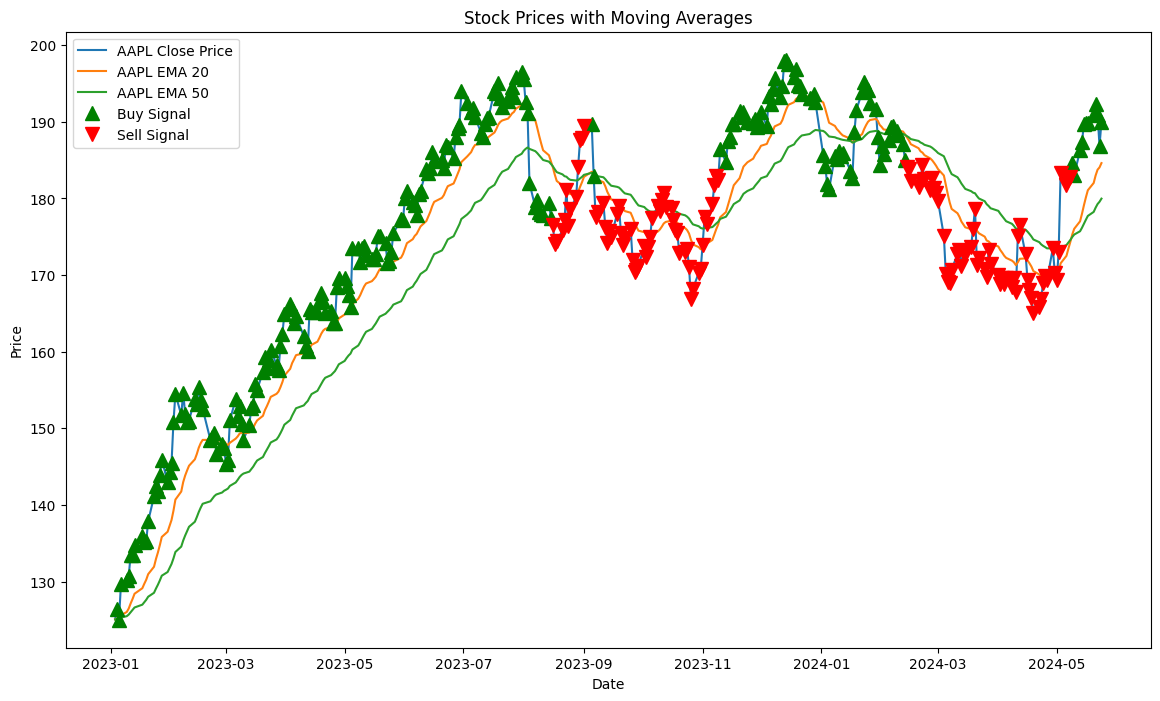

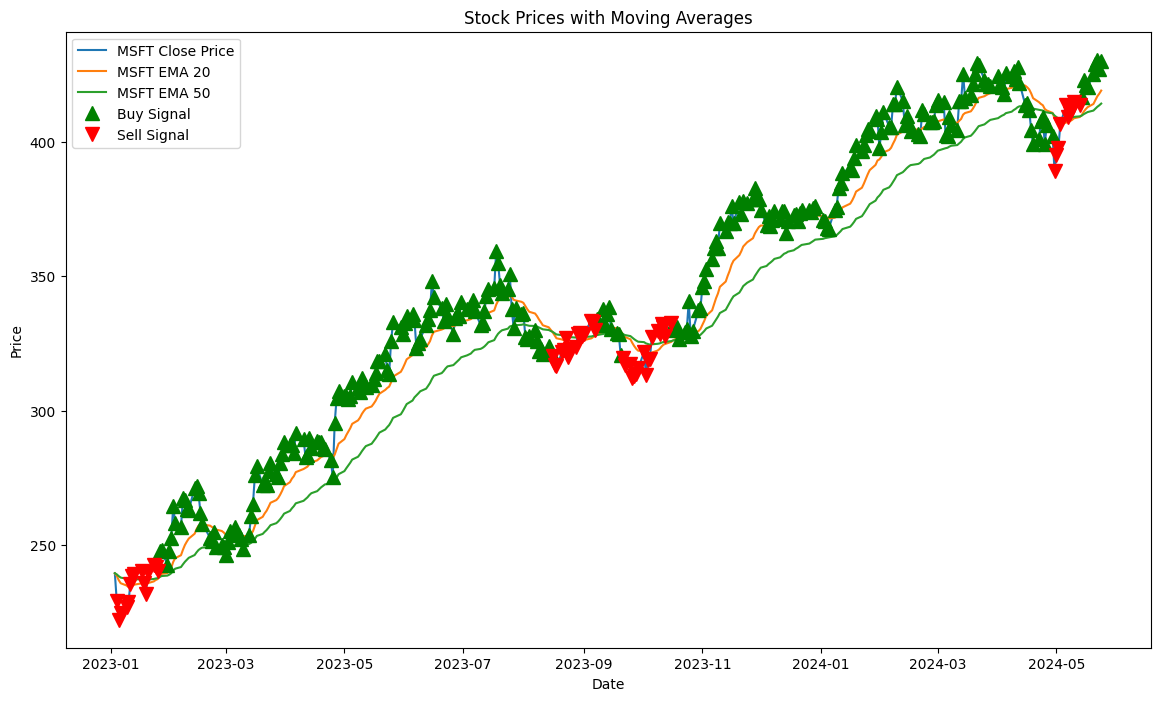

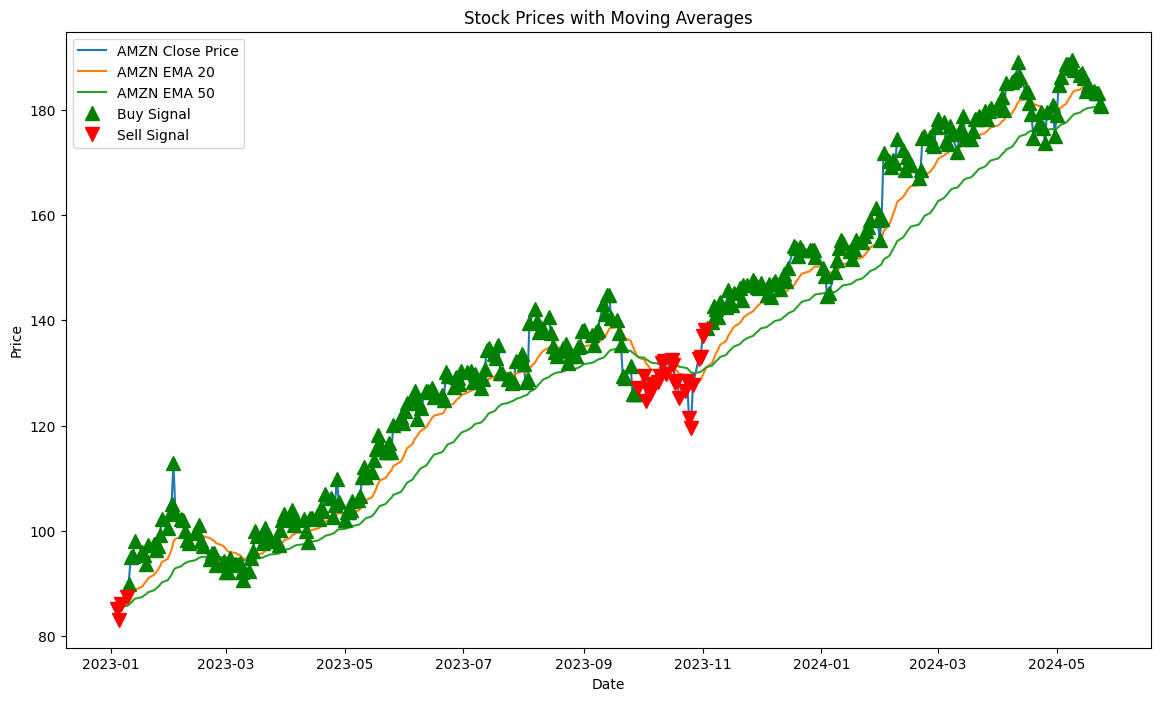

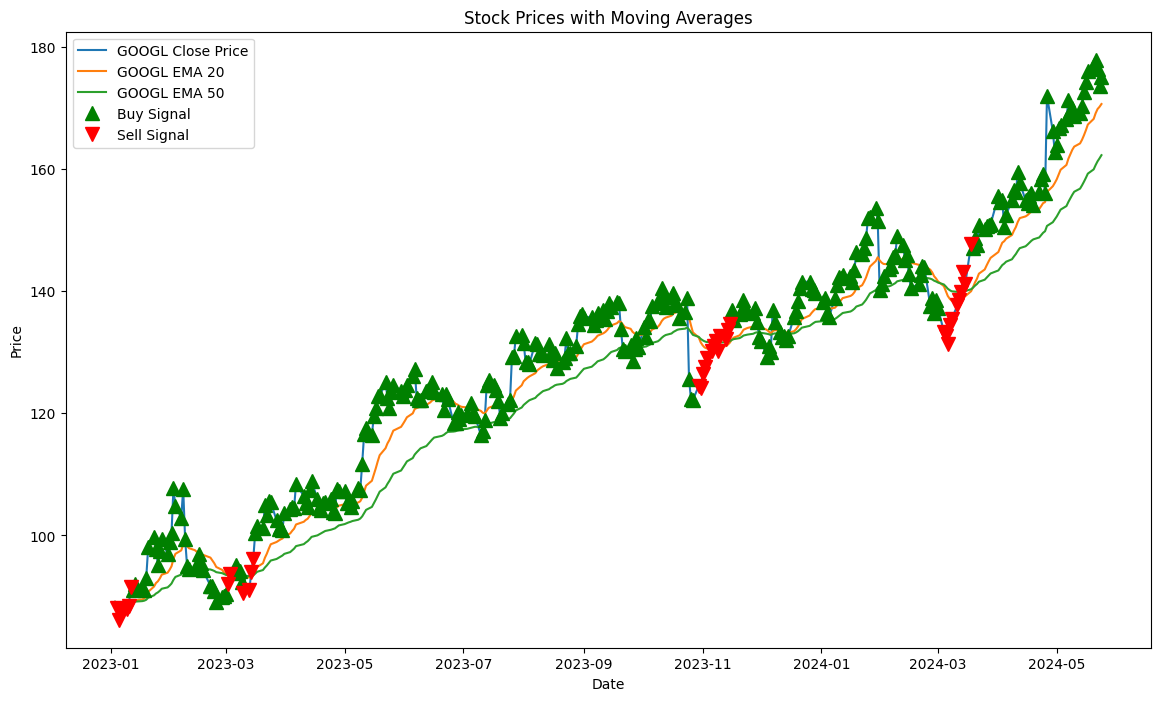

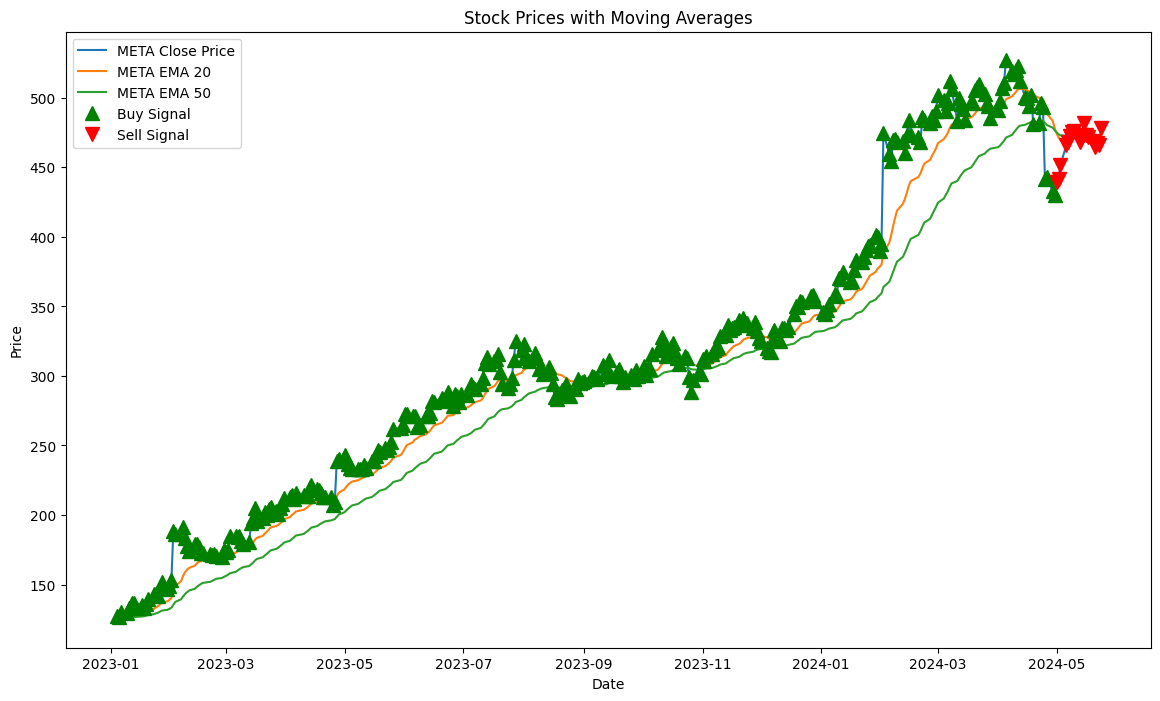

In [13]:
# Visualization: Plot Close Price with SMA and EMA for each symbol
for sym in historical_data['Sym'].unique():
    plt.figure(figsize=(14, 8))

    sym_data = historical_data[historical_data['Sym'] == sym]
    plt.plot(sym_data['Date'].values, sym_data['Close'].values, label=f'{sym} Close Price')
    plt.plot(sym_data['Date'].values, sym_data['EMA_20'].values, label=f'{sym} EMA 20')
    plt.plot(sym_data['Date'].values, sym_data['EMA_50'].values, label=f'{sym} EMA 50')

    # Mark Buy and Sell signals
    buy_signals = sym_data[sym_data['Buy_Signal'] == 1]
    sell_signals = sym_data[sym_data['Sell_Signal'] == -1]
    plt.plot(buy_signals['Date'].values, buy_signals['Close'].values, '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(sell_signals['Date'].values, sell_signals['Close'].values, 'v', markersize=10, color='r', label='Sell Signal')


    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Moving Averages')
    plt.legend()
    plt.show()


In [18]:
q.close()